# Brain Tumor Identification
By Jonathan Nunez

abstract

# Business Understanding
According the [Clevland Clinic](https://my.clevelandclinic.org/health/diseases/6149-brain-cancer-brain-tumor), a brain tumor is an abnormal growth or mass of cells in or around your brain. Brain tumors can be malignant (cancerous) or benign (noncancerous). Some tumors grow quickly, while others grow slowly with only about one-third of brain tumors being cancerous.

When it comes to manually analyzing and identifying a tumor in the brain, there is always the possibility of misinterpretation due to the medical professional’s fatigue or even lack of time. Not to mention manual analysis of medical images is a slow and labor-intensive process, which can possibly lead to delays in diagnosis. With the development and proper training of an image classification neural network learning algorithm, not only may it be possible to detect and classify brain tumors, but a machine learning model can analyze the medical image in a timely manner leading to faster diagnosis possibly leading to prompt treatment.

# Data Understanding
The dataset used for this project is the [Brain Tumor Dataset](https://www.kaggle.com/datasets/ishans24/brain-tumor-dataset) from Kaggle datasets, this dataset contains about 10,500 images of Brain MRI scans compiled from multiple publicly available datasets on [Kaggle](https://www.kaggle.com) and [Figshare](https://figshare.com/). The data is divided between 4 classes, 'no_tumor', 'glioma', 'pituitary', and 'meningioma'.

#### Dataset Sources
* [Navoneel Chakrabarty – Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)
* [Sartaj Bhuvaji et al. – Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)
* [Tom Backert – Brain Tumor MRI Data (multi-source collection)](https://www.kaggle.com/datasets/tombackert/brain-tumor-mri-data)
* [Deniz Kavi – Brain Tumor Image Dataset (Converted from Jun Cheng’s dataset)](https://www.kaggle.com/datasets/denizkavi1/brain-tumor)
* [Masoud Nickparvar – Brain Tumor MRI Dataset (merged from multiple open datasets)](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)


In [ ]:
# For Google Colab only
# Cell output cleared as it only contains installation progress
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]
!pip install split-folders

In [ ]:
# Importing tools and modules for data preperation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img

import random
import splitfolders

In [ ]:
# Code to create kaggle path for data download
# Code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"",
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [ ]:
# Downloading kaggle dataset
# Cell output cleared as only contains data download progress
!kaggle datasets download -d ishans24/brain-tumor-dataset

# Creating parent folder directory for data unzip
!mkdir /content/brain_tumor_dataset
!unzip brain-tumor-dataset.zip -d /content/brain_tumor_dataset

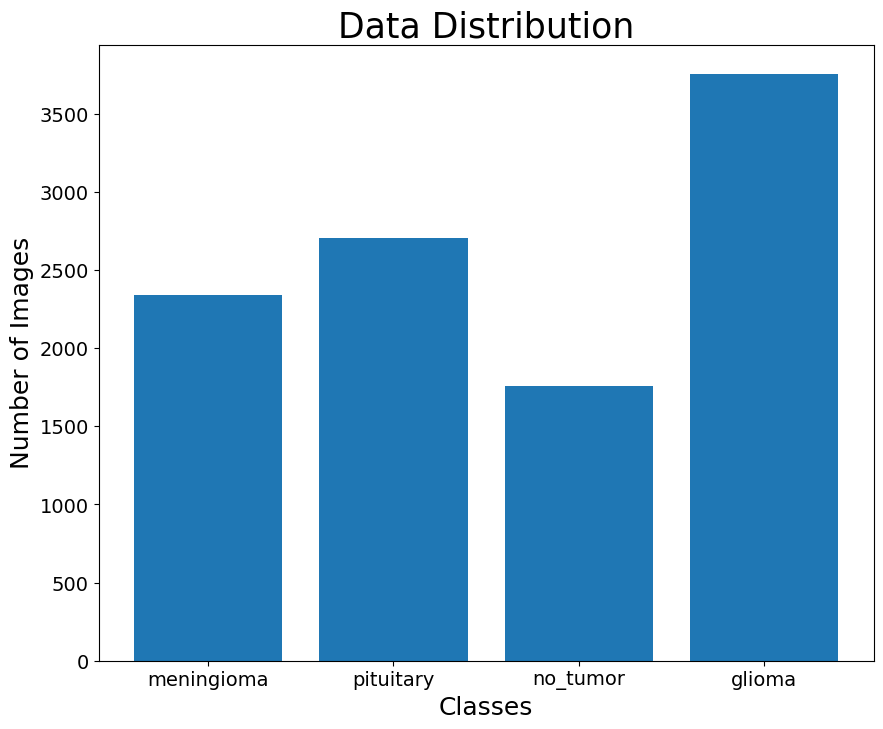

In [ ]:
# Counting the number of images in each class
directory = 'brain_tumor_dataset'
classes = os.listdir(directory)

image_counts = {cls: len(os.listdir(os.path.join(directory, cls))) for cls in classes}
df = pd.Series(image_counts)

# Plotting the distribution of images
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(df.index, df)
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Data Distribution', fontsize=25)
ax.set_xlabel('Classes', fontsize=18)
ax.set_ylabel('Number of Images', fontsize=18);

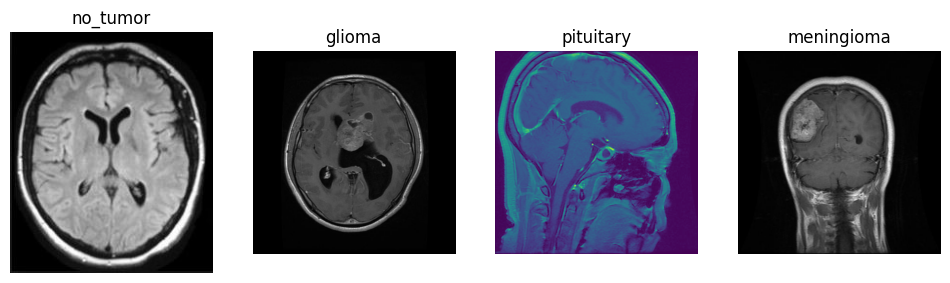

In [ ]:
# Code to randomly display an image from each class
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i, category in enumerate(['glioma', 'meningioma', 'no_tumor', 'pituitary']):
    path = os.path.join(directory, category)
    sample = random.choice(os.listdir(path))
    img = mpimg.imread(os.path.join(path, sample))

    axes[i].imshow(img)
    axes[i].set_title(f"{category}")
    axes[i].axis('off');

## Data preparation
When downloading the data, it comes divided into 4 different directories based off the data’s classes. To make it easier to manage the data I created a parent directory to store all the data. To split the data for model training, I used the splitfolders tool to randomly split the parent directory folder I previously created into train, test, and validation directories with a ratio of .70 for the training data and .15 for both the test and validation data. With the train, test, and validation directories now created I import the data using ImageDataGenerator with a rescale parameter to scale the data as its being imported. By scaling the data as its being imported it allows us to bring in larger amounts of data in and makes it easier to process when creating the train, test, and validation datasets.

In [ ]:
# Splitting data into train, test, and validation data directories
splitfolders.ratio('brain_tumor_dataset', output='b_tumor_data_split', seed=42, ratio=(.7, 0.15, 0.15))

Copying files: 10560 files [00:01, 6547.86 files/s]


In [ ]:
# Directory paths
train_dir = 'b_tumor_data_split/train'
test_dir = 'b_tumor_data_split/test'
val_dir = 'b_tumor_data_split/val'

In [ ]:
# Variable to rescale images as its being imported
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Importing brain tumor image data
train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(256, 256),
                                              batch_size=7390,
                                              seed=42
                                              )

test_generator = datagen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=1588,
                                             seed=42
                                             )

val_generator = datagen.flow_from_directory(val_dir,
                                            target_size=(256, 256),
                                            batch_size=1582,
                                            seed=42
                                            )

Found 7390 images belonging to 4 classes.
Found 1588 images belonging to 4 classes.
Found 1582 images belonging to 4 classes.


In [ ]:
# Creating datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Modeling
For the model building, I imported tools from the Tensorflow library, primarily Keras tools.
From Tensorflows’s Keras I imported the models I would test and use such as DenseNet, and ResNet as well as the layer modules I’d use to help tune the model such as dense, and dropout layers to name a few.

Before choosing a final model I created 3 base models, a Convolutional Neural Network (CNN), DenseNet, and ResNet model. From these models I went with the DenseNet model to further fine tune as it showed the best results with the least number of layers. To help with the model tuning, I implemented an early stop callback to keep track of the model’s validation loss and stop the model should its validation loss no longer decrease or start to consecutively increase over a span of 3 epochs.

The learning rate I chose for this model is Adaptive Moment Estimation (Adam). I went with this optimizer as it uses momentum as well as RMSprop to automatically adjust the models learning rate leading to faster convergence. As the data used for this model is imbalanced the model would begin to overfit, I implemented dropout layers to randomly drop 50% of its layers. I also added L2 kernel regularizers to penalize the majority class in the data so the model can better learn and understand the data from the minority classes lowering overfitting as much as possible.

In [ ]:
# Importing modeling tools and modules
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from keras.applications import ResNet50, DenseNet121

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [ ]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

In [ ]:
data_dict = {
    'Train Data': (train_images, train_labels),
    'Val Data': (val_images, val_labels)
}

### Base CNN Model

In [ ]:
base_cnn = Sequential()

In [ ]:
base_cnn.add(layers.Input(shape=(256, 256, 3)))
base_cnn.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(64, activation='relu'))
base_cnn.add(layers.Dropout(0.5))
base_cnn.add(layers.Dense(4, activation='softmax'))

In [ ]:
base_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
base_cnn_results = base_cnn.fit(train_images, train_labels,
                                epochs=20,
                                batch_size=100,
                                validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.4549 - loss: 1.5847 - val_accuracy: 0.7693 - val_loss: 0.5718
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7443 - loss: 0.6024 - val_accuracy: 0.8369 - val_loss: 0.4038
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8204 - loss: 0.4296 - val_accuracy: 0.8565 - val_loss: 0.3526
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8461 - loss: 0.3761 - val_accuracy: 0.8925 - val_loss: 0.2851
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8852 - loss: 0.2822 - val_accuracy: 0.9052 - val_loss: 0.2452
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9052 - loss: 0.2415 - val_accuracy: 0.9153 - val_loss: 0.2423
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9138 - loss: 0.2140 - val_accuracy: 0.9153 - val_loss: 0.2354
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9264 - loss: 0.1895 - val_accuracy: 0.9235 -

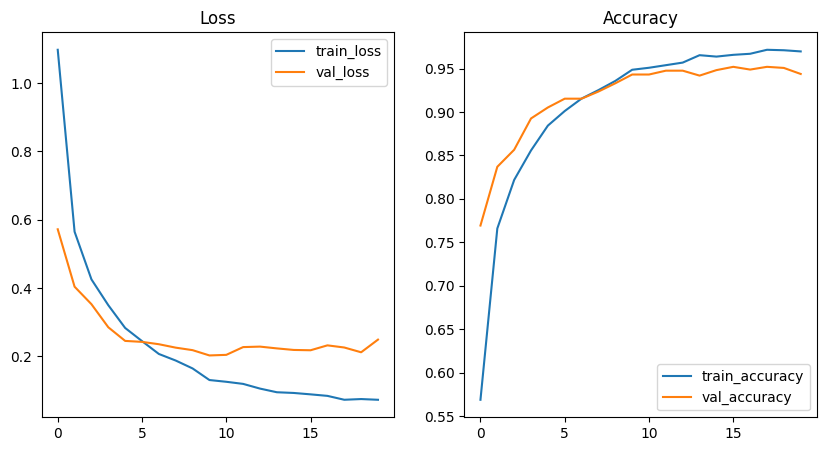

In [ ]:
plot_results([base_cnn_results])

In [ ]:
model_evaluation(base_cnn, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9964 - loss: 0.0118
Train Data, Loss: 0.0130, Accuracy: 0.9962
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9413 - loss: 0.2661
Val Data, Loss: 0.2489, Accuracy: 0.9437


### Base DenseNet Model

In [ ]:
dn_base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_densenet = Sequential()
base_densenet.add(dn_base_model)
base_densenet.add(layers.GlobalAveragePooling2D())
base_densenet.add(layers.Dense(64, activation='relu'))
base_densenet.add(layers.Dropout(0.5))
base_densenet.add(layers.Dense(4, activation='softmax'))

In [ ]:
base_densenet.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
# May take about 10 min to run with colab's A100 runtime
base_densenet_results = base_densenet.fit(train_images, train_labels,
                                          epochs=20,
                                          batch_size=100,
                                          validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.7716 - loss: 0.6061 - val_accuracy: 0.6460 - val_loss: 2.8937
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.9375 - loss: 0.2016 - val_accuracy: 0.8698 - val_loss: 0.4903
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.9594 - loss: 0.1394 - val_accuracy: 0.8970 - val_loss: 0.3220
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.9692 - loss: 0.0955 - val_accuracy: 0.9254 - val_loss: 0.3378
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.9801 - loss: 0.0742 - val_accuracy: 0.9482 - val_loss: 0.2036
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.9774 - loss: 0.0806 - val_accuracy: 0.8805 - val_loss: 0.5035
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.9818 - loss: 0.0610 - val_accuracy: 0.9526 - val_loss: 0.1643
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9857 - loss: 0.0559 - val_accura

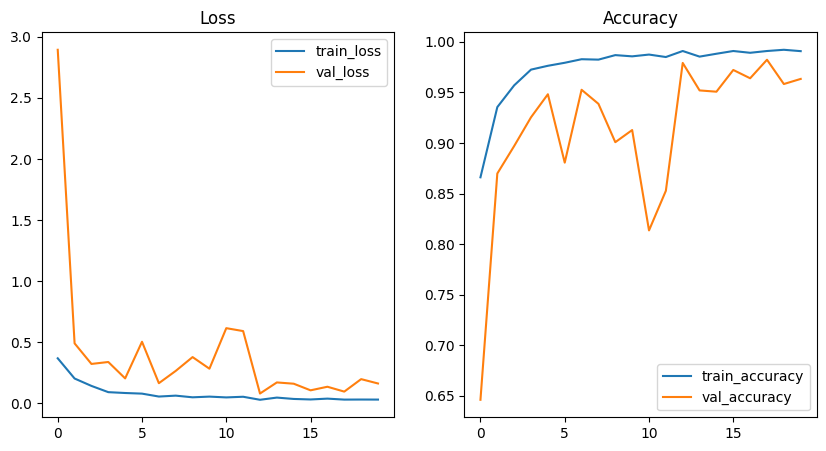

In [ ]:
plot_results([base_densenet_results])

In [ ]:
model_evaluation(base_densenet, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.9832 - loss: 0.0541
Train Data, Loss: 0.0492, Accuracy: 0.9832
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - accuracy: 0.9612 - loss: 0.1752
Val Data, Loss: 0.1620, Accuracy: 0.9633


### Base ResNet Model

In [ ]:
rn_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_resnet = Sequential()
base_resnet.add(rn_base_model)
base_resnet.add(layers.GlobalAveragePooling2D())
base_resnet.add(layers.Dense(64, activation='relu'))
base_resnet.add(layers.Dropout(0.5))
base_resnet.add(layers.Dense(4, activation='softmax'))

In [ ]:
base_resnet.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
base_resnet_results = base_resnet.fit(train_images, train_labels,
                                      epochs=20,
                                      batch_size=100,
                                      validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 125s 791ms/step - accuracy: 0.7779 - loss: 0.6345 - val_accuracy: 0.3559 - val_loss: 2.3241
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9334 - loss: 0.1977 - val_accuracy: 0.3559 - val_loss: 1.8186
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.9598 - loss: 0.1340 - val_accuracy: 0.3559 - val_loss: 3.0505
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.9687 - loss: 0.1026 - val_accuracy: 0.3552 - val_loss: 1.5835
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9689 - loss: 0.0978 - val_accuracy: 0.3698 - val_loss: 1.9000
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.9804 - loss: 0.0680 - val_accuracy: 0.1650 - val_loss: 6.1994
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.9779 - loss: 0.0806 - val_accuracy: 0.1233 - val_loss: 3.3341
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9820 - loss: 0.0546 - val_acc

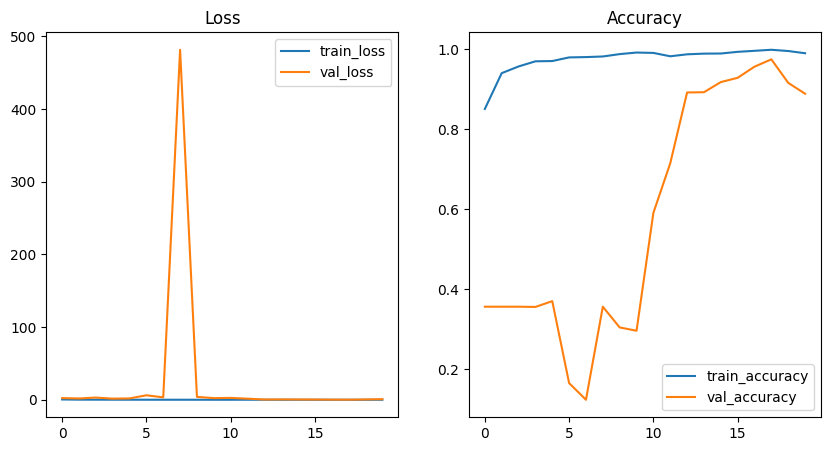

In [ ]:
plot_results([base_resnet_results])

In [ ]:
model_evaluation(base_resnet, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9216 - loss: 0.6025
Train Data, Loss: 0.5910, Accuracy: 0.9181
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8939 - loss: 0.7728
Val Data, Loss: 0.8074, Accuracy: 0.8881


# DenseNet Model

In [ ]:
# Creating early stop callback variable
early_stop = EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5, restore_best_weights=True)

In [ ]:
dn_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [ ]:
# May take up to 10 min to run with colab's A100 runtime
dn_model = Sequential()
dn_model.add(dn_base_model)
dn_model.add(layers.GlobalAveragePooling2D())
dn_model.add(layers.Dense(75, activation='relu', kernel_regularizer=l2(l2=0.30)))
dn_model.add(layers.Dropout(0.5))
dn_model.add(layers.Dense(50, activation='relu'))
dn_model.add(layers.Dropout(0.5))
dn_model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(l2=0.30)))
dn_model.add(layers.Dense(4, activation='softmax'))

dn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

dn_model_results = dn_model.fit(train_images, train_labels,
                                epochs=20,
                                batch_size=250,
                                validation_data=(val_images, val_labels),
                                callbacks=[early_stop])

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 409s 6s/step - accuracy: 0.6430 - loss: 37.6705 - val_accuracy: 0.9134 - val_loss: 14.5825
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.9385 - loss: 11.1879 - val_accuracy: 0.9463 - val_loss: 4.8358
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.9709 - loss: 3.9652 - val_accuracy: 0.9646 - val_loss: 2.5244
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.9799 - loss: 2.2400 - val_accuracy: 0.9020 - val_loss: 1.8862
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 383ms/step - accuracy: 0.9838 - loss: 1.5841 - val_accuracy: 0.6688 - val_loss: 2.2059
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - accuracy: 0.9788 - loss: 1.1876 - val_accuracy: 0.9381 - val_loss: 1.0815
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.9910 - loss: 0.8567 - val_accuracy: 0.9551 - val_loss: 0.7838
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step - accuracy: 0.9907 - loss: 0.6521 - val_acc

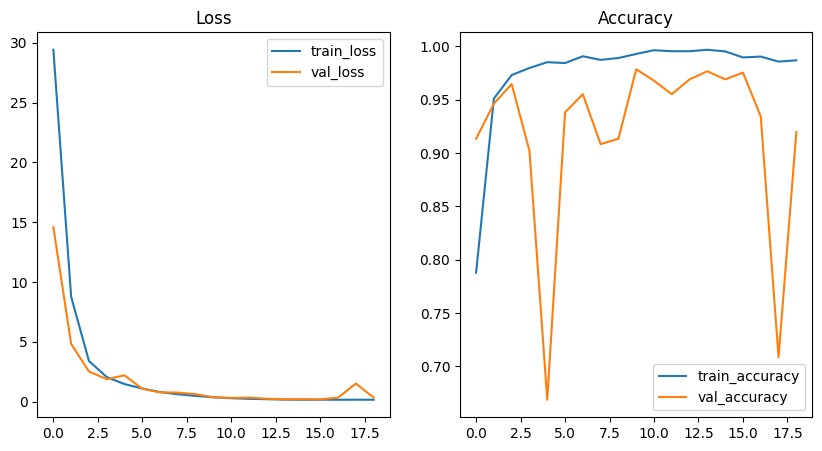

In [ ]:
plot_results([dn_model_results])

In [ ]:
model_evaluation(dn_model, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.9909 - loss: 0.1349
Train Data, Loss: 0.1362, Accuracy: 0.9908
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - accuracy: 0.9794 - loss: 0.1841
Val Data, Loss: 0.1973, Accuracy: 0.9753


# Evaluation
The final model performed very well across classification metrics, for **precision the model averaged a .96, recall .97, and f1score .98**. When evaluating the test data with the final model it was able to properly identify and categorize the data with **98% accuracy and about .15 loss when making its predictions**. But where the model really excels is in its ability to recall what it learned, which is the most important metric when it comes to image identification and classification.

For the tumor positive classes ('glioma', 'meningioma’, 'pituitary'), the recall rates were all close to each other, with the rates of the **three classes averaging at a .97 recall rate**. Further individual breakdown for each tumor positive class recall rate, **glioma .96, meningioma .97, and pituitary .99**. When it comes to the **‘no tumor’ class the model has recall rate of 1.0** meaning the model is able to accurately recall brain scans without tumors 100% of the time.  

Overall, the model performed exceptionally well with all of the classification metrics ratings ranging from the mid to upper 90s. This tells us that the model is precise with its predictions and can recall what it learned well even with an imbalanced dataset.

In [ ]:
final_model = dn_model

final_model.evaluate(test_images, test_labels)

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step - accuracy: 0.9693 - loss: 0.1891


[0.18259461224079132, 0.9754408001899719]

In [ ]:
# Getting test data pedictions
test_img_pred = final_model.predict(test_images)

# Converting test_img_pred and test_labels to single-label format
test_img_pred_labels = np.argmax(test_img_pred, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

# Classification report
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
print(classification_report(test_true_labels, test_img_pred_labels, target_names=class_names))

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.99      0.98       564
  meningioma       0.97      0.97      0.97       352
    no_tumor       0.97      0.99      0.98       265
   pituitary       1.00      0.96      0.98       407

    accuracy                           0.98      1588
   macro avg       0.98      0.98      0.98      1588
weighted avg       0.98      0.98      0.98      1588



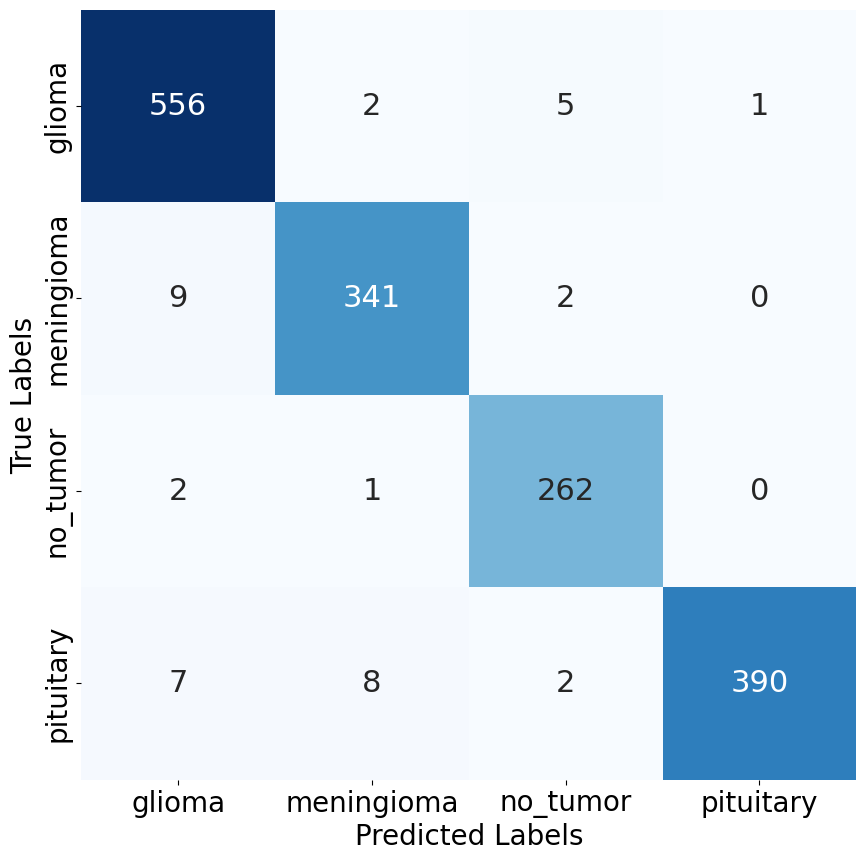

In [ ]:
# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(test_true_labels, test_img_pred_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size' : 22}, cbar=False)

ax.tick_params(axis='both', labelsize=20)
ax.set_yticks([0.5, 1.5, 2.5, 3.5], class_names)
ax.set_xticks([0.5, 1.5, 2.5, 3.5], class_names)
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.set_ylabel('True Labels', fontsize=20);

# Limitations
A limitation when working with this data would be Image inconsistency. By inconsistent I mean that for the majority of the ‘no tumor’ class images are in greyscale while the other 3 classes have blue hues and tints. An inconsistency like this can easily be picked up by the model possibly leading to misclassification of the few images in greyscale for the majority classes.

# Next Steps
While the model did perform exceptionally well there is still room for improvement in certain aspects of the model, primarily in its ability to generalize as during training the model’s results would have minor fluctuations with the occasional big spike.

# Conclusion